<a href="https://colab.research.google.com/github/abhee235/ML/blob/master/Tensor_with_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib import gridspec
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{: .1f}' .format 

In [0]:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
chdf["median_house_value"] /= 1000

chdf = chdf.reindex(np.random.permutation(chdf.index))



In [0]:
def preprocess_features(chdf) :
  selected_features = chdf[[
      "latitude",
      "longitude",
      "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"
  ]]
  
  processed_features = selected_features.copy()
  
  #synthetic features
  
  processed_features["rooms_per_person"] = chdf["total_rooms"] / chdf["population"]
  
  return processed_features
  
def preprocess_targets(chdf) :
  output_frame = pd.DataFrame()
  output_frame["median_house_value"] = chdf["median_house_value"]
  return output_frame

In [71]:
trn_ex = preprocess_features(chdf.head(12000))
trn_ex

trn_trg = preprocess_targets(chdf.head(12000))
trn_trg.describe()

vld_ex = preprocess_features(chdf.tail(5000))
vld_ex.describe()

vld_trg = preprocess_targets(chdf.tail(5000))
vld_trg.describe()

chdf["longitude"].head(12000).describe()
chdf["median_house_value"].head(12000).describe()

count    12000.0
mean       207.3
std        115.7
min         15.0
25%        119.9
50%        181.0
75%        264.3
max        500.0
Name: median_house_value, dtype: float64

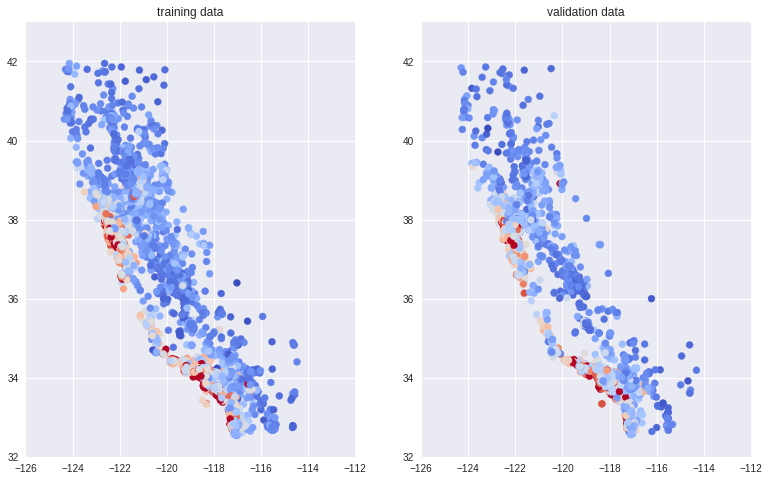

In [73]:
#plot Latitude/longitude vs median_house_value for data analysis 

plt.figure(figsize=(13,8))
ax = plt.subplot(1,2,1)
ax.set_autoscaley_on(False)
ax.set_autoscalex_on(False)
ax.set_title("training data")
ax.set_xlim([-126,-112])
ax.set_ylim([32, 43])
plt.scatter(trn_ex["longitude"],
           trn_ex["latitude"],
           cmap= 'coolwarm',
           c = trn_trg["median_house_value"]/ trn_trg["median_house_value"].max())
#_ =plt.plot()

#plt.figure(figsize=(13,8))
ax = plt.subplot(1,2,2)
ax.set_autoscaley_on(False)
ax.set_autoscalex_on(False)
ax.set_title("validation data")
ax.set_xlim([-126,-112])
ax.set_ylim([32, 43])
plt.scatter(vld_ex["longitude"],
           vld_ex["latitude"],
           cmap= 'coolwarm',
           c = vld_trg["median_house_value"]/ vld_trg["median_house_value"].max())
_ =plt.plot()